In [1]:
import random
from datetime import datetime

import joblib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
BATCH_SIZE = 64
RANDOM_SEED = 0
IMG_SIZE = (160, 160)
IMG_SHAPE = (160, 160, 3)
EPOCHS = 20
LEARNING_RATE = 0.0001

STARTED_TIMESTAMP = datetime.now().strftime("%Y%m%d-%H%M%S")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
# load model
class_names = joblib.load("../model/class_names-20220312-062819.z")

model = tf.keras.models.load_model("../model/mobilenet-20220312-062819")
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

2022-03-19 08:23:02.766037: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-19 08:23:02.824946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-19 08:23:02.825328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-03-19 08:23:02.826926: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow wi

In [4]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    convLayer = model.get_layer(last_conv_layer_name).output
    grad_model = tf.keras.models.Model(
        [model.inputs], [convLayer, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_logits, prediction_logits = grad_model(img_array)
        pred_index = tf.argmax(prediction_logits[0])
        loss_value = prediction_logits[:, pred_index]

        print("prediction_logits", prediction_logits.shape)
        print("prediction_logits", prediction_logits)
        print("")
        print("last_conv_layer_logits", last_conv_layer_logits.shape)
        print("last_conv_layer_logits", last_conv_layer_logits)
        print("")
        print("pred_index", pred_index)
        print("")
        print("loss_value", loss_value.shape)
        print("loss_value", loss_value)
        print("")
        #np.savetxt("last_conv_layer_logits.txt", last_conv_layer_logits.numpy())

        # This is the gradient of the output neuron (top predicted or chosen)
        # with regard to the output feature map of the last conv layer
        grads = tape.gradient(loss_value, last_conv_layer_logits)
        print("grads", grads.shape)
        print("grads", grads)
        print("")

        # This is a vector where each entry is the mean intensity of the gradient
        # over a specific feature map channel
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        print("pooled_grads", pooled_grads.shape)
        print("pooled_grads", pooled_grads[:10])
        print("")

        # We multiply each channel in the feature map array
        # by "how important this channel is" with regard to the top predicted class
        # then sum all the channels to obtain the heatmap class activation
        heatmap = tf.matmul(last_conv_layer_logits[0], pooled_grads[..., tf.newaxis])
        print("heatmap matmul", heatmap.shape)
        print("heatmap matmul", heatmap)
        print("")

        heatmap = tf.squeeze(heatmap)
        print("heatmap squeeze", heatmap.shape)
        print("heatmap squeeze", heatmap)
        print("")

        # For visualization purpose, we will also normalize the heatmap between 0 & 1
        heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
        print("heatmap max", heatmap.shape)
        print("heatmap max", heatmap)
        print("")

        return heatmap.numpy()

2022-03-19 08:23:09.960785: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-19 08:23:11.648558: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-03-19 08:23:13.507818: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-19 08:23:13.541844: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-19 08:23:13.541898: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-03-19 08:23:13.575391: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-03-19 08:23:13.575489: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx co

prediction_logits (1, 4)
prediction_logits tf.Tensor([[ 2.9399517  -0.40479442 -2.8308663  -2.086748  ]], shape=(1, 4), dtype=float32)

last_conv_layer_logits (1, 5, 5, 1280)
last_conv_layer_logits tf.Tensor(
[[[[ 0.03644972  1.3612725  -0.07495838 ... -0.7682729   0.8622386
    -0.623267  ]
   [-0.37190786  1.6131213  -0.4638886  ... -1.1271515   1.7337543
    -0.9272685 ]
   [-0.19416672  1.9343584  -0.26091287 ... -0.9453179   1.7419645
    -0.90497607]
   [-0.5906179   1.7968069  -0.34340513 ... -0.80044     1.1229789
    -0.663611  ]
   [ 0.08481693  1.0277677   0.16364759 ... -1.0131978   0.617653
    -0.13236547]]

  [[-0.28180408  1.2694124  -0.51070243 ... -0.6492283   1.9339684
    -0.8953787 ]
   [-0.3161923   1.5936625  -0.3812737  ... -0.5981116   2.5805845
    -0.8227344 ]
   [-0.1719735   1.6236185  -0.22446255 ... -0.4983146   2.2209427
    -0.24973926]
   [-0.6347756   1.9535518   0.02501275 ... -0.5830315   1.5340747
    -0.46910724]
   [-0.41320425  1.0610504   0.018

Text(0.5, 1.0, 'Predicted: Bacterialblight')

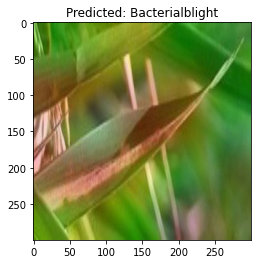

In [5]:
img_path = '../dataset/test/Bacterialblight/BACTERAILBLIGHT3_011.jpg'
#img_path = '../dataset/Blast/BLAST1_010.jpg'
#img_path = '../dataset/Brownspot/brownspot_orig_001.jpg'
#img_path = '../dataset/Tungro/TUNGRO1_004.jpg'
alpha = 0.4

pred_img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
pred_img = tf.keras.preprocessing.image.img_to_array(pred_img)
pred_img = preprocess_input(pred_img)
pred_img = np.expand_dims(pred_img, axis=0)

# predict
predicted = tf.nn.softmax(model.predict(pred_img))
predicted = tf.argmax(predicted, axis=1)

# Rescale heatmap to a range 0-255
heatmap = make_gradcam_heatmap(pred_img, model, "Conv_1")
heatmap = np.uint8(255 * heatmap)

# Use RGB values of the colormap
nipy_cm = plt.cm.get_cmap("nipy_spectral")
nipy_colors = nipy_cm(np.arange(256))[:, :3]
cm_heatmap = nipy_colors[heatmap]

# load original image
original_img = tf.keras.preprocessing.image.load_img(img_path)
original_img = tf.keras.preprocessing.image.img_to_array(original_img)

# Create an image with RGB colorized heatmap
cm_heatmap = tf.keras.preprocessing.image.array_to_img(cm_heatmap)
cm_heatmap = cm_heatmap.resize((original_img.shape[1], original_img.shape[0]))
cm_heatmap = tf.keras.preprocessing.image.img_to_array(cm_heatmap)

# Superimpose the heatmap on original image
superimposed_img = cm_heatmap * alpha + original_img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
plt.imshow(superimposed_img)
plt.title("Predicted: {}".format(class_names[predicted[0]]))